# GCN Implementation

```
@inproceedings{kipf2017semi,
  title={Semi-Supervised Classification with Graph Convolutional Networks},
  author={Kipf, Thomas N. and Welling, Max},
  booktitle={International Conference on Learning Representations (ICLR)},
  year={2017}
}
```

## Import Library

In [1]:
import dgl
import os
import torch
import itertools
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
from utils.startup_data_set import COMP4222Dataset_hetero
from utils.PredictorClasses import *
from utils.CustomMetrics import *
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Hypermeters

In [2]:
val_ratio = 0.1
test_ratio = 0.1

# Hyperparameters
n_hidden = 64
n_layers = 2
dropout = 0.8
lr = 0.01
early_stopping = 10
ep = 1500

## Load Dataset

In [3]:
import numpy as np
np.random.seed(0)

In [4]:
graph = COMP4222Dataset_hetero()[0]
graph = dgl.to_homogeneous(graph,ndata=['feat'],edata=['feat'])
graph

7594


Graph(num_nodes=25446, num_edges=45621,
      ndata_schemes={'feat': Scheme(shape=(221,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(23,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})

In [5]:
in_feats = graph.ndata['feat'].shape[1]
in_feats

221

## Generate Postitve Graph and Negative Graph with Spliting

In [6]:
from utils.CustomUtilities import generate_neg_graph, generate_pos_graph
train_g, train_pos_g, val_pos_g, test_pos_g, *_ = \
    generate_pos_graph(graph, val_ratio, test_ratio)

train_g

Graph(num_nodes=25446, num_edges=61943,
      ndata_schemes={'feat': Scheme(shape=(221,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(23,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})

In [7]:
train_neg_g, val_neg_g, test_neg_g = \
    generate_neg_graph(graph, val_ratio, test_ratio)

train_neg_g

Graph(num_nodes=25446, num_edges=36497,
      ndata_schemes={}
      edata_schemes={})

## Model Training

### Model Setup

In [8]:
class GCN(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 out_dim):
        super().__init__()
        self.layers = nn.ModuleList()
        # two-layer GCN
        self.layers.append(
            dglnn.GraphConv(in_feats, n_hidden, activation=F.relu)
        )
        self.layers.append(dglnn.GraphConv(n_hidden, out_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, g, features):
        h = features
        for i, layer in enumerate(self.layers):
            if i != 0:
                h = self.dropout(h)
            h = layer(g, h)
        return h

In [15]:
gat_model = GCN(
    in_feats,
    n_hidden,
    n_layers).to(device)

pred = MLPPredictor(2).to(device)

### Training Loop

In [17]:
import itertools

train_loss, val_loss = [], []
train_AUC, val_AUC = [], []
stop = 0

optimizer = torch.optim.Adam(itertools.chain(gat_model.parameters(), pred.parameters()), lr=lr)

for e in range(ep):
    # forward
    h = gat_model(train_g, train_g.ndata['feat'].float()).to(device)
    pos_score = pred(train_pos_g.to(device), h.to(device))
    neg_score = pred(train_neg_g.to(device), h.to(device))
    loss = compute_loss(pos_score, neg_score)
    train_loss.append(loss.item())
    train_AUC.append(compute_auc(pos_score, neg_score))

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # validation
    v_pos_score = pred(val_pos_g.to(device), h)
    v_neg_score = pred(val_neg_g.to(device), h)
    v_loss = compute_loss(v_pos_score, v_neg_score)
    val_loss.append(v_loss.item())
    val_AUC.append(compute_auc(v_pos_score, v_neg_score))

    #verbose
    if e % 10 == 0:
        print('Epoch: {} \t Train loss: {} \t Val loss: {} \t Train AUC: {} \t Val AUC: {}'.format(e, round(loss.item(), 3), round(v_loss.item(), 3), round(train_AUC[-1],3), round(val_AUC[-1], 3)))


    # early stopping
    if e > 10:
        if v_loss.item() > sum(val_loss[-5:])/5:
            stop += 1
        else: 
            stop = 0
        if stop >= early_stopping:
            print("Early Stopped at Epoch {}".format(e))
            break

Epoch: 0 	 Train loss: 0.694 	 Val loss: 0.694 	 Train AUC: 0.479 	 Val AUC: 0.473
Epoch: 10 	 Train loss: 0.653 	 Val loss: 0.675 	 Train AUC: 0.781 	 Val AUC: 0.671
Epoch: 20 	 Train loss: 0.575 	 Val loss: 0.669 	 Train AUC: 0.822 	 Val AUC: 0.713
Early Stopped at Epoch 29


In [18]:
# testing AUC
with torch.no_grad():
    pos_score = pred(test_pos_g.to(device), h)
    neg_score = pred(test_neg_g.to(device), h)
    print('AUC:', compute_auc(pos_score, neg_score))

AUC: 0.7140932826519361


### Result Plotting

Text(0, 0.5, 'Loss')

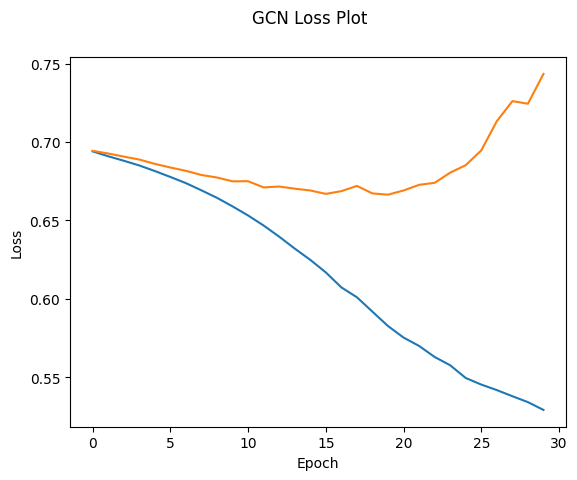

In [19]:
fig = plt.figure()
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label = 'validation loss')
fig.suptitle('GCN Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')

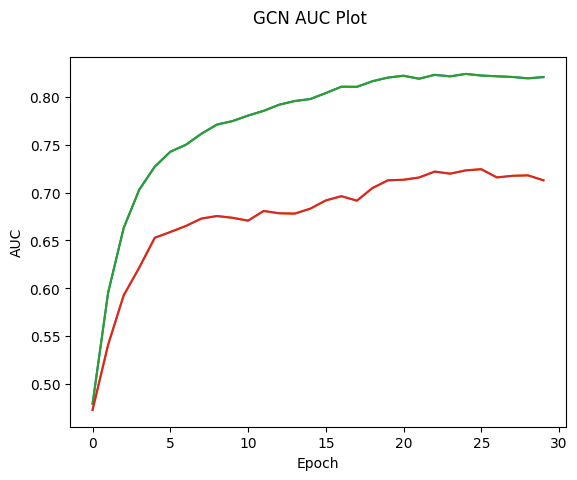

In [20]:
fig = plt.figure()
plt.plot(train_AUC, label='training AUC')
plt.plot(val_AUC, label = 'validation AUC')
fig.suptitle('GCN AUC Plot')
plt.xlabel('Epoch')
plt.ylabel('AUC')

plt.plot(train_AUC)
plt.plot(val_AUC)